In [1]:
import numpy      as     np
from   scipy      import stats
from   matplotlib import pyplot as plt, patches
from   iminuit    import Minuit

In [2]:
mu1, sigma1 = 9 , 3
mu2, sigma2 = 11, 3
mub, sigmab = 5 , 10

xsec_sig, xsec_bkg = 5, 10
xsec_tot           = xsec_sig + xsec_bkg
frac_sig, frac_bkg = xsec_sig/xsec_tot, xsec_bkg/xsec_tot

lumi = 100

n_exp_sig, n_exp_bkg, n_exp = lumi*xsec_sig, lumi*xsec_bkg, lumi * xsec_tot
n_sample = int(1e3)

print(f"n_exp is {n_exp}")
print(f"n_sample is {n_sample}")

n_exp is 1500
n_sample is 1000


In [3]:
def pdf_only_1 (x) :
    return stats.norm.pdf(x, mu1, sigma1)

def pdf_only_2 (x) :
    return stats.norm.pdf(x, mu2, sigma2)

def pdf_only_bkg (x) :
    return stats.norm.pdf(x, mub, sigmab)

def cdf_only_1 (x) :
    return stats.norm.cdf(x, mu1, sigma1)

def cdf_only_2 (x) :
    return stats.norm.cdf(x, mu2, sigma2)

def cdf_only_bkg (x) :
    return stats.norm.cdf(x, mub, sigmab)

def pdf1 (x) :
    return frac_sig*pdf_only_1(x) + frac_bkg*pdf_only_bkg(x)

def pdf2 (x) :
    return frac_sig*pdf_only_2(x) + frac_bkg*pdf_only_bkg(x)

def cdf1 (x) :
    return frac_sig*cdf_only_1(x) + frac_bkg*cdf_only_bkg(x)

def cdf2 (x) :
    return frac_sig*cdf_only_2(x) + frac_bkg*cdf_only_bkg(x)

def q (x) :
    return -2. * np.log(pdf2 (x) / pdf1 (x))

def q_exp_1 (x) :
    return pdf1 (x) * q(x)

def q_exp_2 (x) :
    return pdf2 (x) * q(x)

def sample_only_1 (N) :
    return mu1 + sigma1 * np.random.normal(size=N)

def sample_only_2 (N) :
    return mu2 + sigma2 * np.random.normal(size=N)

def sample_only_b (N) :
    return mub + sigmab * np.random.normal(size=N)

def sample1 (N) :
    N_sig = int(N*frac_sig)
    N_bkg = N - N_sig
    ds = np.concatenate([sample_only_1(N_sig), sample_only_b(N_bkg)])
    np.random.shuffle(ds)
    return ds

def sample2 (N) :
    N_sig = int(N*frac_sig)
    N_bkg = N - N_sig
    ds = np.concatenate([sample_only_2(N_sig), sample_only_b(N_bkg)])
    np.random.shuffle(ds)
    return ds
    

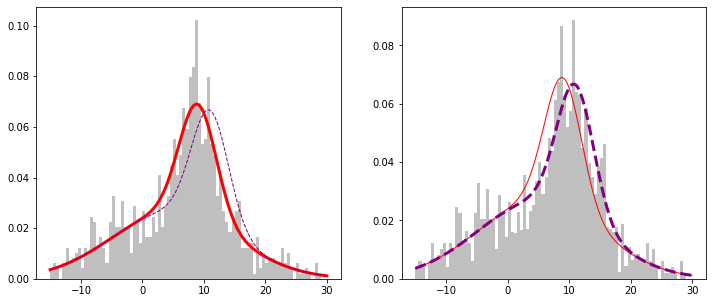

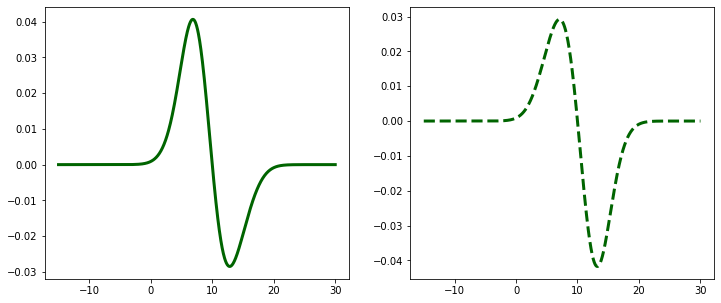

In [4]:
dataset  = sample1(n_sample)
weights1 = np.full(shape=(n_sample,), fill_value=n_exp/n_sample)
weights2 = weights1 * pdf2(dataset) / pdf1(dataset)

bins = np.linspace(-15, 30, 91)
pts  = np.linspace(-15, 30, 901)
pdf1_profile , pdf2_profile  = pdf1   (pts), pdf2   (pts)
qexp1_profile, qexp2_profile = q_exp_1(pts), q_exp_2(pts)

fig = plt.figure(figsize=(12, 5))
ax  = fig.add_subplot(1, 2, 1)
ax.hist(dataset, bins=bins, weights=weights1, density=True, color="grey", alpha=0.5)
ax.plot(pts, pdf1_profile, "-" , c="r"     , linewidth=3)
ax.plot(pts, pdf2_profile, "--", c="purple", linewidth=1)
ax  = fig.add_subplot(1, 2, 2)
ax.hist(dataset, bins=bins, weights=weights2, density=True, color="grey", alpha=0.5)
ax.plot(pts, pdf1_profile, "-" , c="r"     , linewidth=1)
ax.plot(pts, pdf2_profile, "--", c="purple", linewidth=3)
plt.show()

fig = plt.figure(figsize=(12, 5))
ax  = fig.add_subplot(1, 2, 1)
ax.plot(pts, qexp1_profile, "-" , c="darkgreen", linewidth=3)
ax  = fig.add_subplot(1, 2, 2)
ax.plot(pts, qexp2_profile, "--", c="darkgreen", linewidth=3)
plt.show()

In [5]:
#  loss_func over whole dataset using numpy

def get_n1_n2 (bin_edge_lo, bin_width, batch_size=None) :
    bin_edge_hi = bin_edge_lo + bin_width
    ds, ws1, ws2 = dataset, weights1, weights2
    if type(batch_size) != type(None) :
        idx = np.random.choice(len(ds), size=(batch_size,))
        ds, ws1, ws2 = ds[idx], ws1[idx], ws2[idx]
    n_1 = np.sum([w for x,w in zip(dataset,weights1) if (x>bin_edge_lo) and (x<bin_edge_hi)])
    n_2 = np.sum([w for x,w in zip(dataset,weights2) if (x>bin_edge_lo) and (x<bin_edge_hi)])
    return n_1, n_2

def get_q (n_1, n_2) :
    q_ = np.log(n_2/n_1) + (n_1 + n_1*n_1)/n_2 + n_2 - 2*n_1 - 1
    return q_

def loss_func (p, batch_size=None) :
    bin_edge_lo, bin_width = p[0], np.exp(p[1])
    n_1, n_2 = get_n1_n2 (bin_edge_lo, bin_width, batch_size)
    return - np.log(get_q(n_1, n_2))

def grad_loss (p, batch_size=None) :
    bin_edge_lo, bin_width = p[0], np.exp(p[1])
    n_1, n_2 = get_n1_n2 (bin_edge_lo, bin_width, batch_size)
    dq_dn1 = (1+2*n_1)/n_2 - 2 - 1/n_1
    dq_dn2 = 1 + (1/n_2) - (n_1*n_1 + n_1)/(n_2*n_2)
    grad_A = lambda A, w : xsec_tot * lumi * (dq_dn1*(pdf1(A+w)-pdf1(A)) + dq_dn2*(pdf2(A+w)-pdf2(A)))
    grad_B = lambda A, w : xsec_tot * lumi * w * (dq_dn1*pdf1(A+w) + dq_dn2*pdf2(A+w))
    q_     = get_q (n_1, n_2)
    return - np.array([grad_A(bin_edge_lo, bin_width), grad_B(bin_edge_lo, bin_width)]) / q_


In [6]:
import sys

params1 = [-1, np.log(6 )]
params2 = [17, np.log(15)]
lr      = 1e-1

p1_record = [[params1[0], np.exp(params1[1])]]
p2_record = [[params2[0], np.exp(params2[1])]]

train_idx, train_loss1 = 0., []
while (train_idx<300) or (train_loss1[-1]<train_loss1[-2]-1e-3) :
    params1 = params1 - lr * grad_loss(params1, batch_size=50)
    p1_record.append([params1[0], np.exp(params1[1])])
    train_idx = train_idx + 1
    if train_idx % 100 == 0 :
        train_loss1.append(loss_func(params1))
    if train_idx % 100 == 0 : 
        sys.stdout.write(f"\r{train_idx} {train_loss1[-1]}")
p1_record = np.array(p1_record)

print("\n", p1_record[-1])

train_idx, train_loss2 = 0., []
while (train_idx<300) or (train_loss2[-1]<train_loss2[-2]-1e-3) :
    params2 = params2 - lr * grad_loss(params2, batch_size=50)
    p2_record.append([params2[0], np.exp(params2[1])])
    train_idx = train_idx + 1
    if train_idx % 100 == 0 :
        train_loss2.append(loss_func(params2))
    if train_idx % 100 == 0 : 
        sys.stdout.write(f"\r{train_idx} {train_loss2[-1]}")
p2_record = np.array(p2_record)

print("\n", p2_record[-1])

800.0 -3.5927711035430937
 [2.5911419  6.37700486]
400.0 -3.4285327401317853
 [11.0898948   7.23961829]


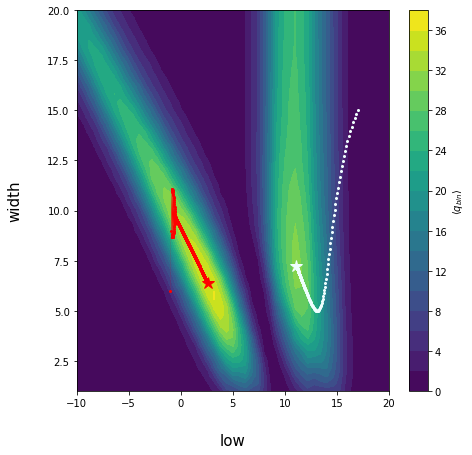

In [7]:
x_axis, y_axis = np.linspace(-10, 20, 51), np.linspace(1, 20, 51)
X, Y = np.meshgrid(x_axis, y_axis, indexing="ij")

Z = np.zeros(shape=X.shape)
for i,x in enumerate(x_axis) :
    for j,y in enumerate(y_axis) :
        Z[i, j] = np.exp(-loss_func([x, np.log(y)]))
Z = np.ma.masked_array(Z, mask=np.isnan(Z))

fig = plt.figure(figsize=(7, 7))
ax  = fig.add_subplot(1, 1, 1)
cbar = ax.contourf(X, Y, Z, levels=20)
plt.colorbar(cbar, label=r"$\langle q_{bin}\rangle$")
ax.plot(p1_record[:,0] , p1_record[:,1] , "o-", c="red"  , markersize=2 , linewidth=0.1)
ax.plot(p1_record[-1,0], p1_record[-1,1], "*" , c="red"  , markersize=12, linewidth=0.5)
ax.plot(p2_record[:,0] , p2_record[:,1] , "o-", c="azure", markersize=2 , linewidth=0.1)
ax.plot(p2_record[-1,0], p2_record[-1,1], "*" , c="azure", markersize=12, linewidth=0.5)
ax.set_ylabel("width", fontsize=15, labelpad=25)
ax.set_xlabel("low"  , fontsize=15, labelpad=25)

plt.show()

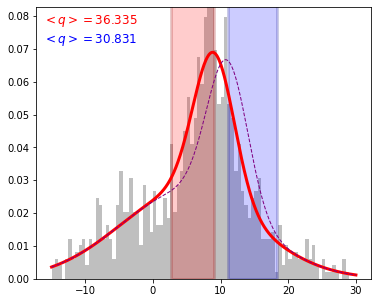

In [8]:
bins = np.linspace(-15, 30, 91)
pts  = np.linspace(-15, 30, 901)
pdf1_profile , pdf2_profile  = pdf1   (pts), pdf2   (pts)
qexp1_profile, qexp2_profile = q_exp_1(pts), q_exp_2(pts)

fig = plt.figure(figsize=(6, 5))
ax  = fig.add_subplot(1, 1, 1)
ax.hist(dataset, bins=bins, weights=weights1, density=True, color="grey", alpha=0.5)
ax.plot(pts, pdf1_profile, "-" , c="r"     , linewidth=3)
ax.plot(pts, pdf2_profile, "--", c="purple", linewidth=1)
rect1 = patches.Rectangle((p1_record[-1][0],0),p1_record[-1][1],1,linewidth=3,
                          edgecolor='darkred',facecolor='r', alpha=0.2)
rect2 = patches.Rectangle((p2_record[-1][0],0),p2_record[-1][1],1,linewidth=3,
                          edgecolor='darkblue',facecolor='blue', alpha=0.2)
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.text(0.02, 0.98, f"$<q>={np.exp(-train_loss1[-1]):.3f}$", ha="left", va="top", c="r", fontsize=12, transform=ax.transAxes)
ax.text(0.02, 0.91, f"$<q>={np.exp(-train_loss2[-1]):.3f}$", ha="left", va="top", c="b", fontsize=12, transform=ax.transAxes)
ax.set_ylim([0, 1.2*np.max(pdf1_profile)])
plt.show()

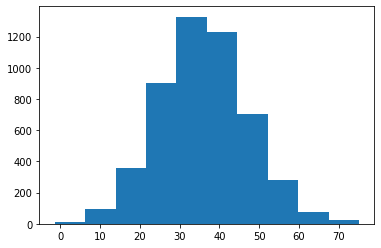

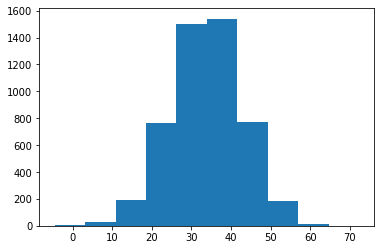

In [9]:
bin_edge_lo_A, bin_width_A = p1_record[-1][0], p1_record[-1][1]
bin_edge_lo_B, bin_width_B = p2_record[-1][0], p2_record[-1][1]
bin_edge_hi_A, bin_edge_hi_B = bin_edge_lo_A + bin_width_A, bin_edge_lo_B + bin_width_B

n1_exp_A = lumi * xsec_tot * (cdf1(bin_edge_hi_A) - cdf1(bin_edge_lo_A))
n1_exp_B = lumi * xsec_tot * (cdf1(bin_edge_hi_B) - cdf1(bin_edge_lo_B))
n2_exp_A = lumi * xsec_tot * (cdf2(bin_edge_hi_A) - cdf2(bin_edge_lo_A))
n2_exp_B = lumi * xsec_tot * (cdf2(bin_edge_hi_B) - cdf2(bin_edge_lo_B))

toy_qA, toy_qB = [], []
for i in range(5000) :
    dataset = sample1(n_exp)
    weights = np.ones(shape=(n_exp,))
    xA = len([True for x in dataset if (x>bin_edge_lo_A) and (x<bin_edge_hi_A)])
    xB = len([True for x in dataset if (x>bin_edge_lo_B) and (x<bin_edge_hi_B)])
    logL2 = stats.norm.logpdf(xA, n2_exp_A, np.sqrt(n2_exp_A))
    logL1 = stats.norm.logpdf(xA, n1_exp_A, np.sqrt(n1_exp_A))
    toy_qA.append(-2*(logL2-logL1))
    logL2 = stats.norm.logpdf(xB, n2_exp_B, np.sqrt(n2_exp_B))
    logL1 = stats.norm.logpdf(xB, n1_exp_B, np.sqrt(n1_exp_B))
    toy_qB.append(-2*(logL2-logL1))
    
plt.hist(toy_qA)
plt.show()

plt.hist(toy_qB)
plt.show()

In [10]:
print("Bin edges")
print(bin_edge_lo_A, bin_edge_hi_A)
print(bin_edge_lo_B, bin_edge_hi_B)

print("\nn1 and n2")
print(n1_exp_A, n2_exp_A)
print(n1_exp_B, n2_exp_B)

print("\nGauss dchi2")
print((n2_exp_A-n1_exp_A)*(n2_exp_A-n1_exp_A)/n2_exp_A)
print((n2_exp_B-n1_exp_B)*(n2_exp_B-n1_exp_B)/n2_exp_B)

print("\nformula")
print((np.log(n2_exp_A/n1_exp_A) + (n1_exp_A+n1_exp_A*n1_exp_A)/n2_exp_A + n2_exp_A - 2*n1_exp_A - 1))
print((np.log(n2_exp_B/n1_exp_B) + (n1_exp_B+n1_exp_B*n1_exp_B)/n2_exp_B + n2_exp_B - 2*n1_exp_B - 1))

print("\ntoys")
print(np.mean([t for t in toy_qA if not np.isnan(t)]))
print(np.mean([t for t in toy_qB if not np.isnan(t)]))

Bin edges
2.591141898008986 8.96814675929791
11.08989479830245 18.32951309263134

n1 and n2
489.14420520911193 372.716578294138
301.0321828808947 420.37586061007585

Gauss dchi2
36.36916922529485
33.88137794890609

formula
36.40970593493944
33.93141243534728

toys
36.118749194801126
33.847026273341136


In [11]:
x_asimov = sample1(n_exp*100)
weights1 = np.full(shape=x_asimov.shape, fill_value=n_exp/len(x_asimov))
weights2 = weights1 * pdf2(x_asimov) / pdf1(x_asimov)

n1_asimov = np.sum([w for x, w in zip(x_asimov,weights1) if (x>bin_edge_lo_A) and (x<bin_edge_hi_A)])
n2_asimov = np.sum([w for x, w in zip(x_asimov,weights2) if (x>bin_edge_lo_A) and (x<bin_edge_hi_A)])

as_TNLL    = lambda x : -2 * stats.norm.logpdf(n1_asimov, x, np.sqrt(x))
as_refTNLL = as_TNLL(n1_asimov)
as_q       = lambda x : as_TNLL(x) - as_refTNLL

print("asimov")
print(as_q(n2_asimov))

n1_asimov = np.sum([w for x, w in zip(x_asimov,weights1) if (x>bin_edge_lo_B) and (x<bin_edge_hi_B)])
n2_asimov = np.sum([w for x, w in zip(x_asimov,weights2) if (x>bin_edge_lo_B) and (x<bin_edge_hi_B)])

print(as_q(n2_asimov))

asimov
36.015511332272794
33.94461200010598
